# Surrogate models training and validation

## Importation

In [11]:
#from ml.bayesian_opt import BO
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from sklearn.model_selection import train_test_split
from ml.neural_net import NN, NN_co2
from ml.neural_net import hyp_param_opt
from ml.validate import evaluate_predictions
from ml.validate import plot_true_vs_predicted, plot_model1_vs_model2, plot_loss
from ml.opt import opt, opt_gp, opt_ismo
from util.time import measure_and_plot_time
from util.normalization import minmax_normalize

import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings("ignore")

# Surrogate Model for Hydration of Cement

In [3]:
########################################################################################
#
#                   LOAD DATA
#
########################################################################################
#importation of data for NN
file_path = '/mnt/disk1/projects/Cement/02-Software_and_Models/Models/InputData/'
name = '_LHS_1000_'
X = pd.read_csv(file_path+ 'recipe_data'+name+'.csv',  index_col=[0])
y = pd.read_csv(file_path+ 'elastic_moduli'+name+'.csv')

train_input, test_input, train_output, test_output = train_test_split(X, y, test_size=0.1, random_state=42)
# suppress low values of aq_gen for a nice relative error
#test_input = test_input[test_output['aq_gen'] > 1e-3]
#test_output = test_output[test_output['aq_gen'] > 1e-3]

# importation of data for GP
#file_path = 'data_repo/'
X = pd.read_csv(file_path+ 'recipe_data'+name+'.csv',  index_col=[0])
y = pd.read_csv(file_path+ 'elastic_moduli'+name+'.csv')

train_input_gp, test_input_gp, train_output_gp, test_output_gp = train_test_split(X, y, test_size=0.2, random_state=42)
# suppress low values of aq_gen for a nice relative error
#test_input_gp = test_input_gp[test_output_gp['aq_gen'] > 1e-4]
#test_output_gp = test_output_gp[test_output_gp['aq_gen'] > 1e-4]

In [6]:
train_output_gp

K          G          E         P
244  59.142693  21.820735  58.293111  0.335727
82   21.886621   9.724853  25.410954  0.306496
316  16.193555   7.713963  19.970792  0.294457
350  62.910556  23.472362  62.628094  0.334082
465  51.533732  18.985468  50.726985  0.335942
..         ...        ...        ...       ...
106  17.686152   8.322476  21.582161  0.296619
270  47.186574  17.644344  47.066545  0.333757
860  17.699450   8.025330  20.914895  0.303055
435  21.824682   9.968015  25.952882  0.301808
102  25.347822  10.566972  27.833222  0.316991

[755 rows x 4 columns]

In [3]:
########################################################################################
#
#                    NEURAL NETWORK
#
########################################################################################
#train the model 

#hydration_NN, hydration_history = NN(train_input, train_output, test_input, test_output)
#hydration_NN.save('model/hydration_2^15.h5')

# load the saved model
model_path = 'model/hydration_2^15.h5'
hydration_NN = load_model(model_path, compile=False)

2024-04-25 10:41:44.935816: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22198 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:21:00.0, compute capability: 8.6


In [4]:
test_output.to_numpy()

array([[0.38816837, 0.26100835, 0.09445354, 0.14059613, 0.11577361],
       [0.40752926, 0.2290191 , 0.07673358, 0.15054137, 0.13617668],
       [0.34754514, 0.23186432, 0.12005669, 0.16344404, 0.13708981],
       ...,
       [0.43439128, 0.2191902 , 0.07665661, 0.13890692, 0.13085498],
       [0.41787155, 0.18446693, 0.07462973, 0.1729322 , 0.15009959],
       [0.14065923, 0.34218278, 0.2191042 , 0.19210237, 0.10595141]])

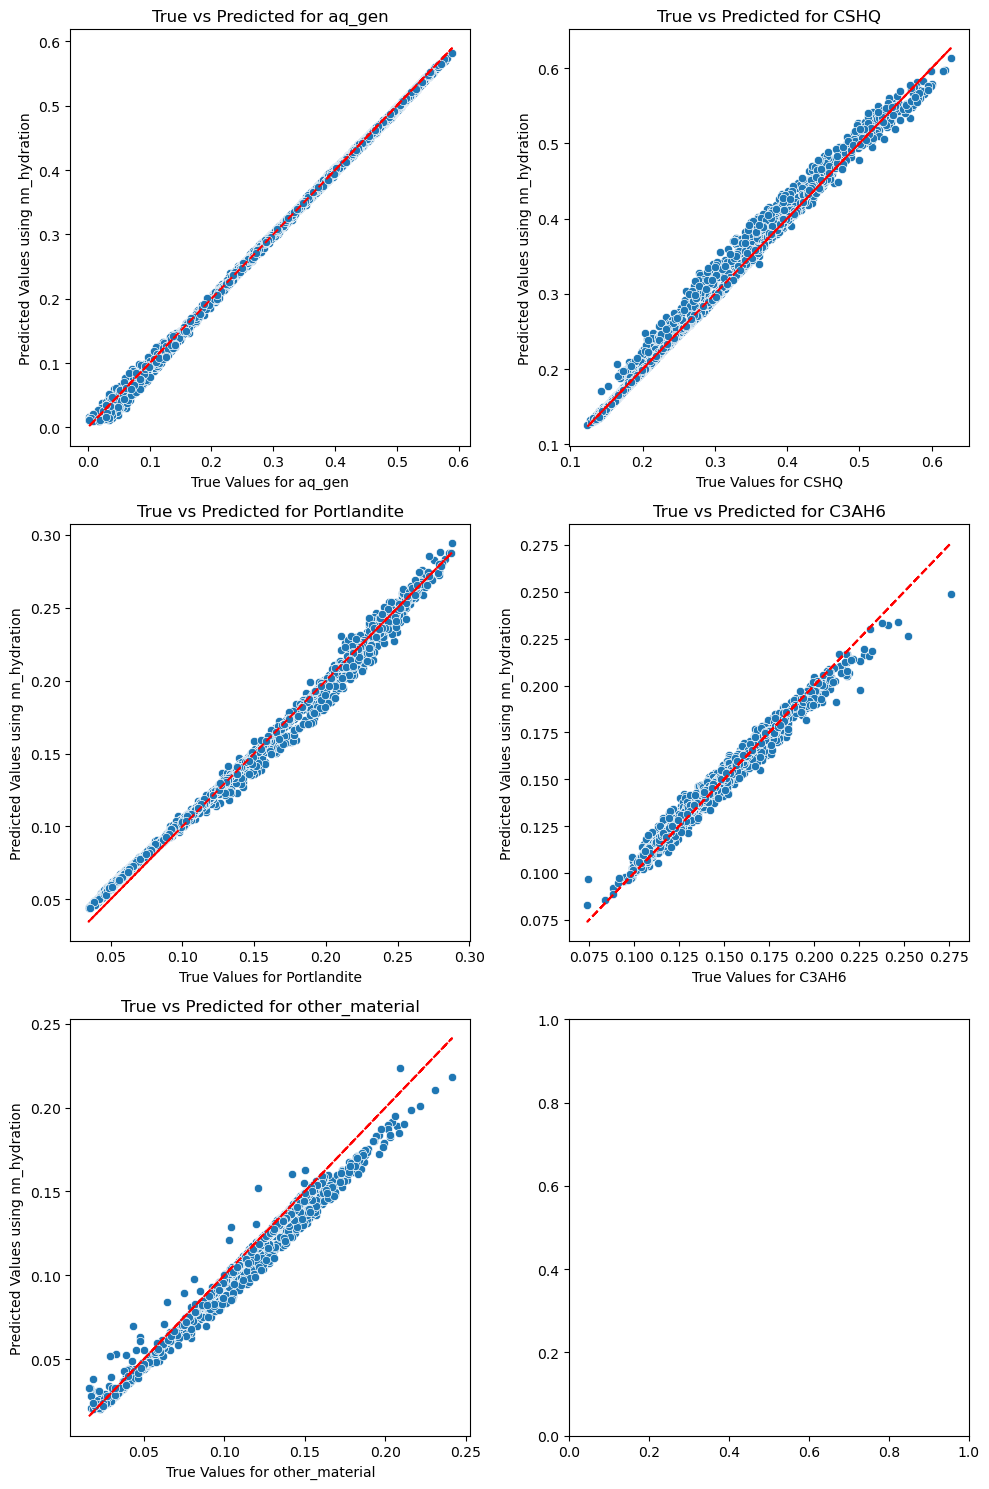

In [5]:
# Print the loss per epoch
#plot_loss(hydration_history, 'Hydration', train_input.shape[0])

# Evaluation of performance of the network
predicted_values = hydration_NN(test_input.to_numpy()).numpy()
model_perf = evaluate_predictions(test_output, predicted_values)
model_perf.to_csv('model_perf/hydration_nn_2^15.csv')

# Plot the true vs predicted plot
plot_true_vs_predicted(test_output, predicted_values, 'nn_hydration')

In [6]:
########################################################################################
#
#                    GAUSSIAN PROCESS
#
########################################################################################
# define the kernel
kernel = 1.0**2 * Matern(length_scale=1, nu=1.5)
# fit the model
gph = GaussianProcessRegressor(kernel).fit(train_input_gp,train_output_gp)
print('The score for the Gaussian Process for hydration is: ', gph.score(train_input_gp, train_output_gp))
print('The mean square error on the test set is: ', np.mean((gph.predict(test_input_gp)-test_output_gp)**2))

The score for the Gaussian Process for hydration is:  0.9999999999998137
The mean square error on the test set is:  3.1655038433292174e-05


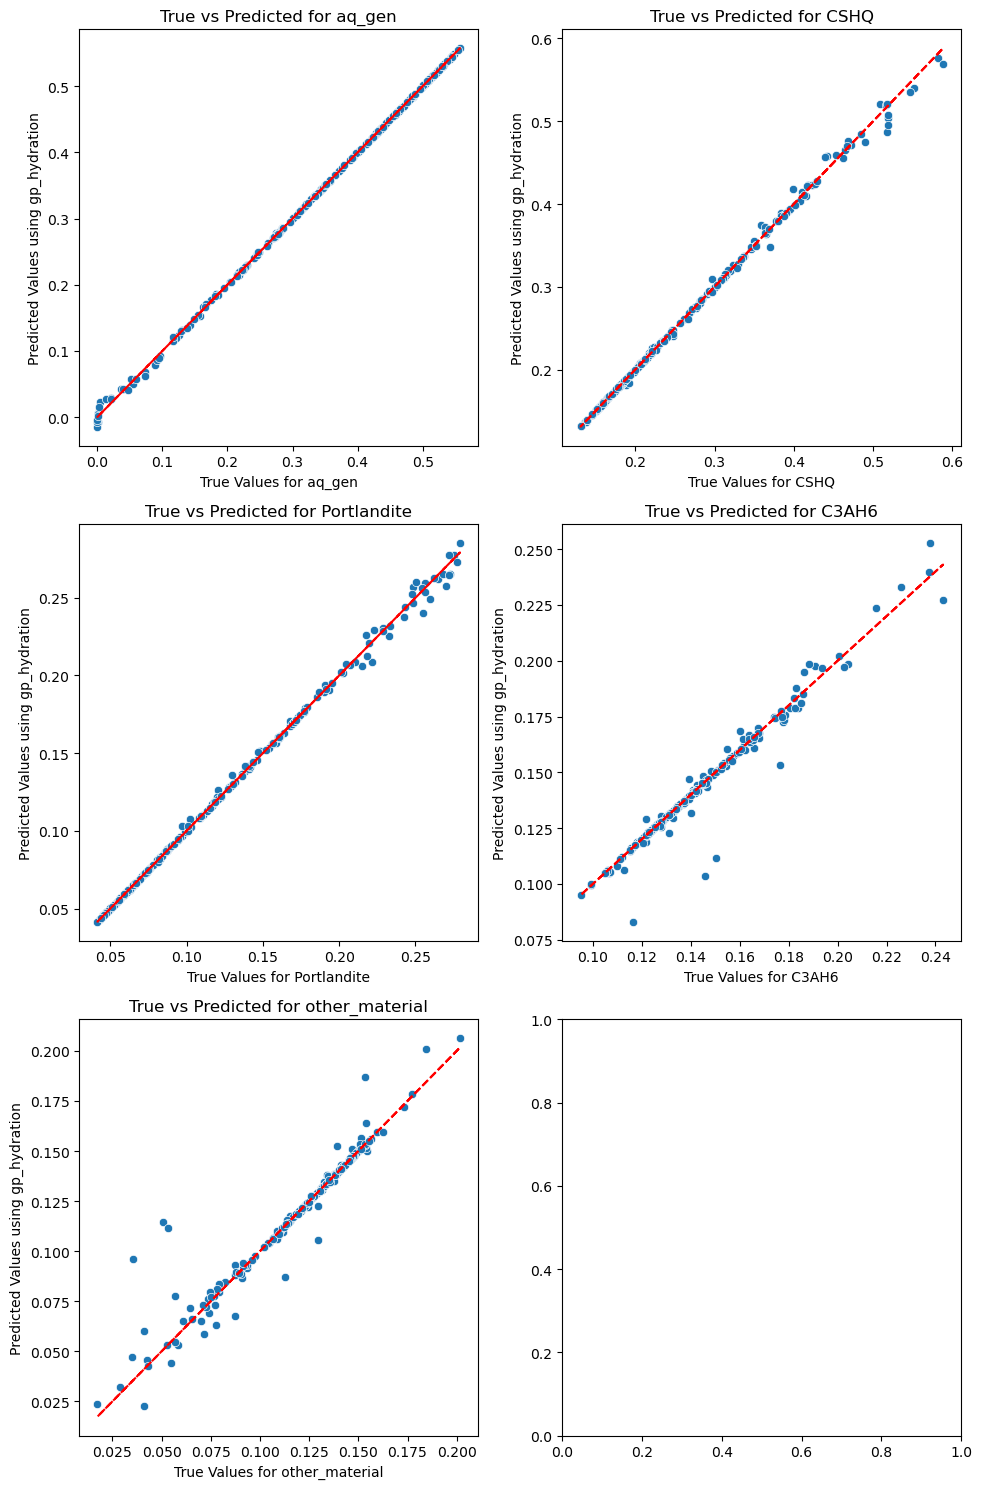

In [9]:
# Evaluation of performance of the GP
predicted_values = gph.predict(test_input_gp)
model_perf = evaluate_predictions(test_output_gp, predicted_values)
#model_perf.to_csv('model_perf/gph_2^10.csv')

# Plot the true vs predicted plot
plot_true_vs_predicted(test_output_gp, predicted_values, 'gp_hydration')

# Model for Elastic Modulus from Recipe

In [18]:
########################################################################################
#
#                   LOAD DATA
#
########################################################################################
########################################################################################
#
#                   LOAD DATA
#
########################################################################################
#importation of data for NN
file_path = '/mnt/disk1/projects/Cement/02-Software_and_Models/Models/InputData/'
name = '_LHS_10000_'
X = pd.read_csv(file_path+ 'recipe_data'+name+'.csv',  index_col=[0])
y = pd.read_csv(file_path+ 'elastic_moduli'+name+'.csv')

y = y[['K','G']]
y

K          G
0     38.607628  14.354662
1     21.084140   9.047453
2     18.887720   8.169235
3     14.811197   7.526439
4     27.671749  11.077108
...         ...        ...
9444  17.201760   7.804758
9445  55.823553  20.297697
9446  14.840696   7.505540
9447  17.891214   7.778571
9448  38.191579  14.561540

[9449 rows x 2 columns]

In [19]:
train_input, test_input, train_elastic, test_elastic = train_test_split(X, y, test_size=0.1, random_state=42)

# importation of data for GP
#file_path = 'data_repo/'
X = pd.read_csv(file_path+ 'recipe_data'+name+'.csv',  index_col=[0])
y = pd.read_csv(file_path+ 'elastic_moduli'+name+'.csv')

train_input_gp, test_input_gp, train_elastic_gp, test_elastic_gp = train_test_split(X, y, test_size=0.2, random_state=42)
# suppress low values of aq_gen for a nice relative error
#test_input_gp = test_input_gp[test_output_gp['aq_gen'] > 1e-4]
#test_output_gp = test_output_gp[test_output_gp['aq_gen'] > 1e-4]

In [20]:
########################################################################################
#
#                    NEURAL NETWORK
#
########################################################################################

# train the neural network
elasticity_NN, elasticity_history = NN(train_input, train_elastic, test_input, test_elastic)
elasticity_NN.save('model/elasticity_1000.h5')
# load the already trained neural network
#model_path = 'model/elasticity_2^15.h5'
#elasticity_NN = load_model(model_path, compile = False)

Constructing the network
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 50)                750       
                                                                 
 dense_23 (Dense)            (None, 50)                2550      
                                                                 
 dense_24 (Dense)            (None, 50)                2550      
                                                                 
 dense_25 (Dense)            (None, 50)                2550      
                                                                 
 dense_26 (Dense)            (None, 50)                2550      
                                                                 
 dense_27 (Dense)            (None, 50)                2550      
                                                                 
 dense_28 (Dense)            

   RelativeError  MeanSquaredError  CoefficientOfDetermination
0       0.023231          1.087643                    0.993865
1       0.020167          0.129081                    0.992859


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

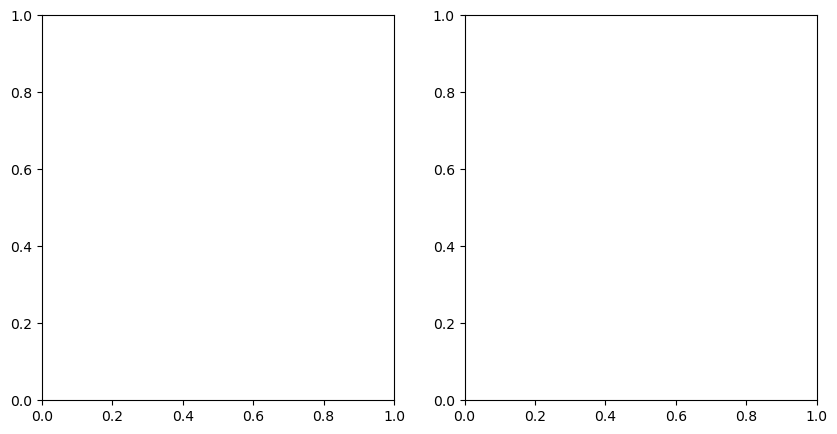

In [21]:
########################################################################################
#
#                    Validation of the neural net
#
########################################################################################
# Print the loss per epoch
#plot_loss(hydration_history, 'Hydration', train_input.shape[0])

# Evaluation of performance of the network
predicted_values = elasticity_NN(test_input.to_numpy()).numpy()
model_perf = evaluate_predictions(test_elastic, predicted_values)
#model_perf.to_csv('model_perf/elasticity_NN_2^15.csv')
print(model_perf)
# Plot the true vs predicted plot
plot_true_vs_predicted(test_elastic, predicted_values, 'elasticity_NN')

In [26]:
predicted_values[:,0]

array([14.598564 , 16.41155  , 23.364351 , 61.339245 , 20.036165 ,
       16.735695 , 18.408987 , 37.41569  , 14.934707 , 20.773254 ,
       18.443731 , 19.985214 , 18.960684 , 19.067142 , 16.457357 ,
       20.345116 , 30.063402 , 16.871964 , 54.450836 , 22.421774 ,
       29.355963 , 16.247202 , 40.40379  , 28.119402 , 23.40215  ,
       59.324688 , 18.612215 , 55.843822 , 16.218119 , 21.361538 ,
       16.715494 , 34.432693 , 16.780771 , 21.12088  , 64.51009  ,
       18.256392 , 25.021265 , 32.31538  , 18.03218  , 17.79662  ,
       17.861444 , 16.501204 , 55.585243 , 53.41668  , 42.108883 ,
       22.408869 , 20.481274 , 41.848408 , 18.664467 , 32.902348 ,
       19.407877 , 49.63177  , 31.083426 , 19.156618 , 22.921103 ,
       17.197853 , 16.370382 , 17.714268 , 57.042793 , 15.204424 ,
       18.268679 , 58.191124 , 18.981155 , 18.220905 , 38.144505 ,
       16.013391 , 41.037117 , 29.313507 , 54.228252 , 14.193084 ,
       17.75188  , 18.156641 , 25.940683 , 14.048036 , 22.7332

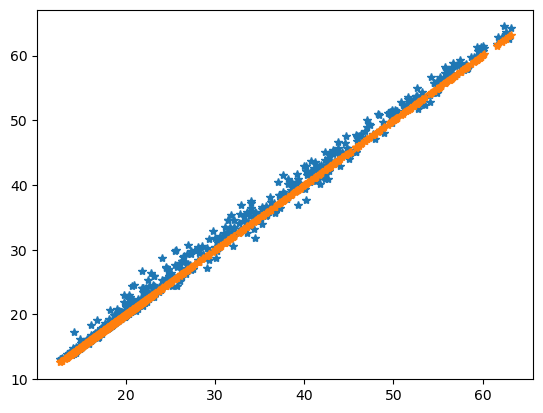

In [29]:
import matplotlib.pyplot as plt 
plt.plot(test_elastic['K'], predicted_values[:,0],'*')
plt.plot(test_elastic['K'], test_elastic['K'],'*')


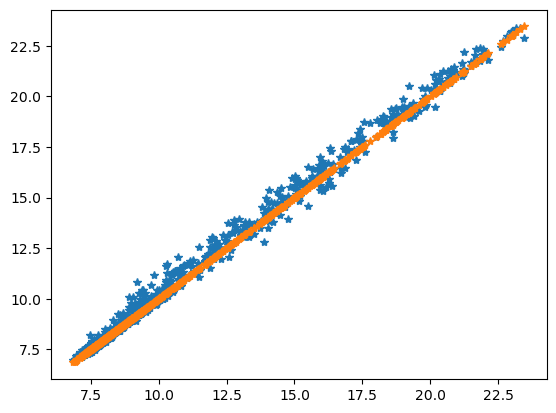

In [30]:
plt.plot(test_elastic['G'], predicted_values[:,1],'*')
plt.plot(test_elastic['G'], test_elastic['G'],'*')


   RelativeError  MeanSquaredError  CoefficientOfDetermination
0       0.022040          0.955405                    0.994611
1       0.017229          0.104238                    0.994233
2       0.016837          0.701256                    0.994779
3       0.036612          0.000216                    0.275144


FileNotFoundError: [Errno 2] No such file or directory: 'plots/elasticity_NN_predict_vs_true.png'

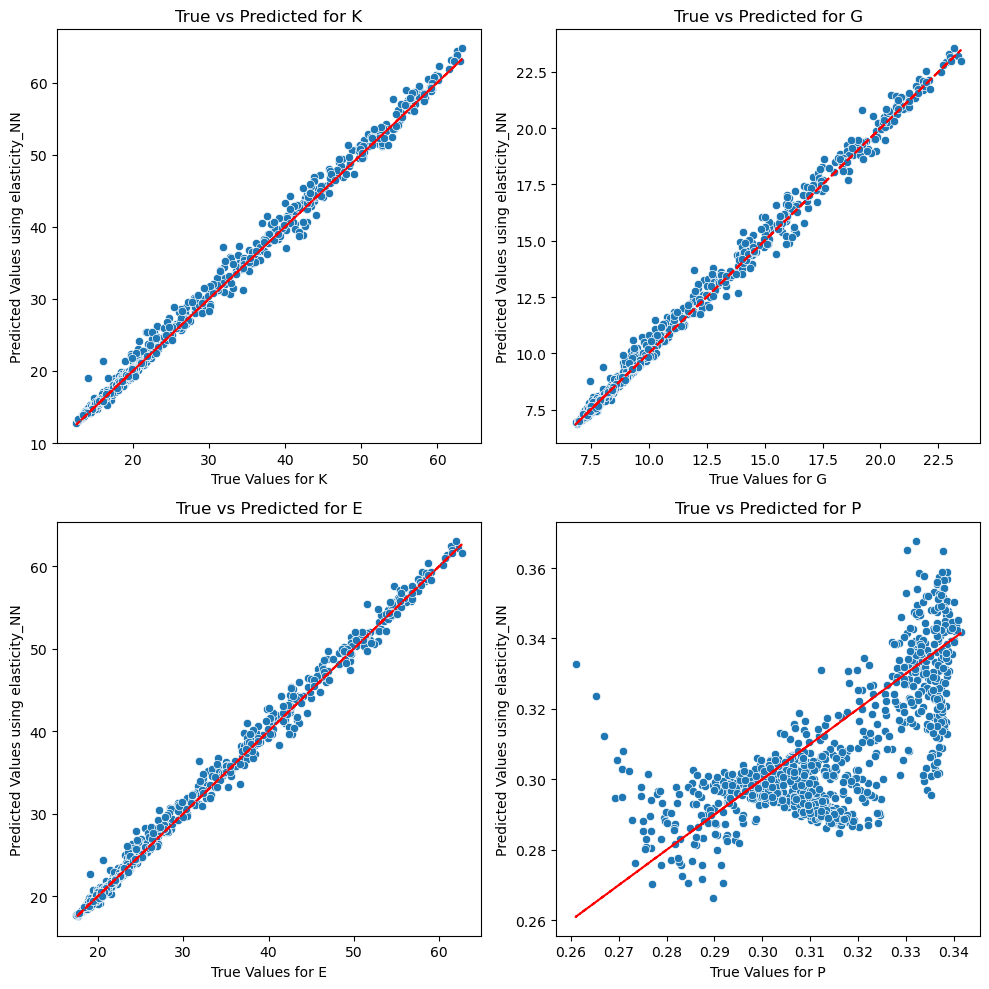

In [14]:
########################################################################################
#
#                    Validation of the neural net
#
########################################################################################
# Print the loss per epoch
#plot_loss(hydration_history, 'Hydration', train_input.shape[0])

# Evaluation of performance of the network
predicted_values = elasticity_NN(test_input.to_numpy()).numpy()
model_perf = evaluate_predictions(test_elastic, predicted_values)
#model_perf.to_csv('model_perf/elasticity_NN_2^15.csv')
print(model_perf)
# Plot the true vs predicted plot
plot_true_vs_predicted(test_elastic, predicted_values, 'elasticity_NN')

In [15]:
########################################################################################
#
#                    GAUSSIAN PROCESS
#
########################################################################################
kernel = 1**2 * Matern(length_scale=1, nu=1.5)

gpg = GaussianProcessRegressor(kernel).fit(train_input_gp, train_elastic_gp)
print('=====================================================')
print('The score for the Gaussian Process for hydration is: ', gpg.score(train_input_gp, train_elastic_gp))
print('The mean square error on the test set is: ', np.mean((gpg.predict(test_input_gp)-test_elastic_gp)**2))

KeyboardInterrupt: 

In [ ]:
########################################################################################
#
#                    Validation of the GP
#
########################################################################################
#Evaluation of the GP
predicted_values = gpg.predict(test_input_gp)
model_perf = evaluate_predictions(test_elastic_gp, predicted_values)
#model_perf.to_csv('model_perf/gpg_2^10.csv')

#Plot true vs predicted
plot_true_vs_predicted(test_elastic_gp, predicted_values, 'elasticity_gp')

# Surrogate Model for Elastic Modulus from Hydration Product

In [13]:
########################################################################################
#
#                   LOAD DATA
#
########################################################################################
file_path = 'data_repo/'
# data for neural net
X = pd.read_csv(file_path+ 'final_hydration_2^15.csv',  index_col=[0])
y = pd.read_csv(file_path+ 'elastic_moduli_2^15.csv')
train_output, test_output, train_elastic, test_elastic = train_test_split(X, y, test_size=0.1, random_state=42)

#data for GP
X = pd.read_csv(file_path+ 'final_hydration_2^10.csv',  index_col=[0])
y = pd.read_csv(file_path+ 'elastic_moduli_2^10.csv')
train_output_gp, test_output_gp, train_elastic_gp, test_elastic_gp = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
########################################################################################
#
#                    NEURAL NETWORK
#
########################################################################################
# train the neural network
#elasticity_from_hydration_NN, efh_hist = NN(train_output, train_elastic, test_output, test_elastic)
#elasticity_from_hydration_NN.save('model/elasticity_from_hydration_2^15.h5')
# load the neural network
model_path = 'model/elasticity_from_hydration_2^15.h5'
elasticity_from_hydration_NN = load_model(model_path, compile=False)

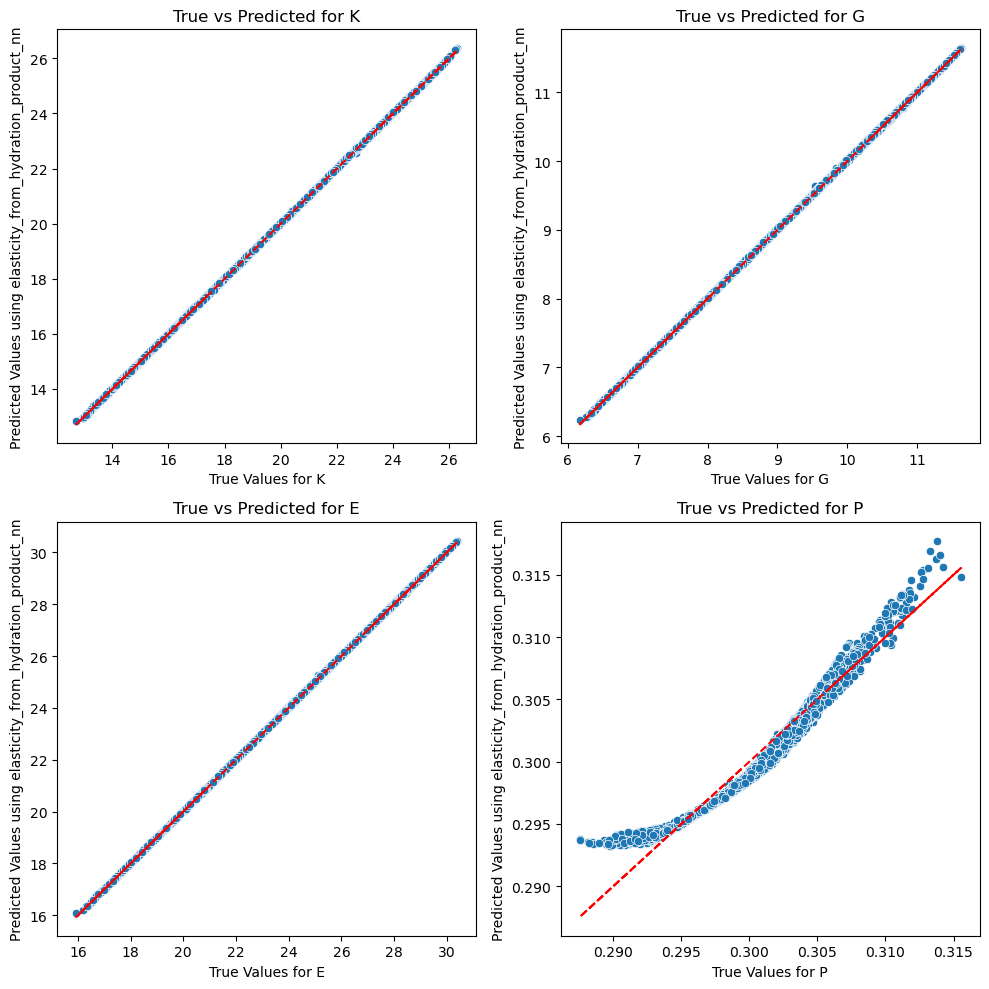

In [15]:
########################################################################################
#
#                    Validation of the neural net
#
########################################################################################
# Evaluate the performance of the neural network
predicted_values = elasticity_from_hydration_NN(test_output.to_numpy()).numpy()
model_perf = evaluate_predictions(test_elastic, predicted_values)
model_perf.to_csv('model_perf/elasticity_from_hydration_nn_2^10.csv')

# Plot the true vs predicted value
plot_true_vs_predicted(test_elastic, predicted_values, 'elasticity_from_hydration_product_nn')

In [16]:
########################################################################################
#
#                    GAUSSIAN PROCESS
#
########################################################################################
#default kernel from sklearn is 1 * RBF(lenght_scale = 1)
gpgh = GaussianProcessRegressor().fit(train_output_gp, train_elastic_gp)
print('The score for the Gaussian Process for hydration is: ', gpgh.score(train_output_gp, train_elastic_gp))
print('The mean square error on the test set is: ', np.mean((gpgh.predict(test_output_gp)-test_elastic_gp)**2))

The score for the Gaussian Process for hydration is:  0.9999958696219339
The mean square error on the test set is:  7.66670071134284e-08


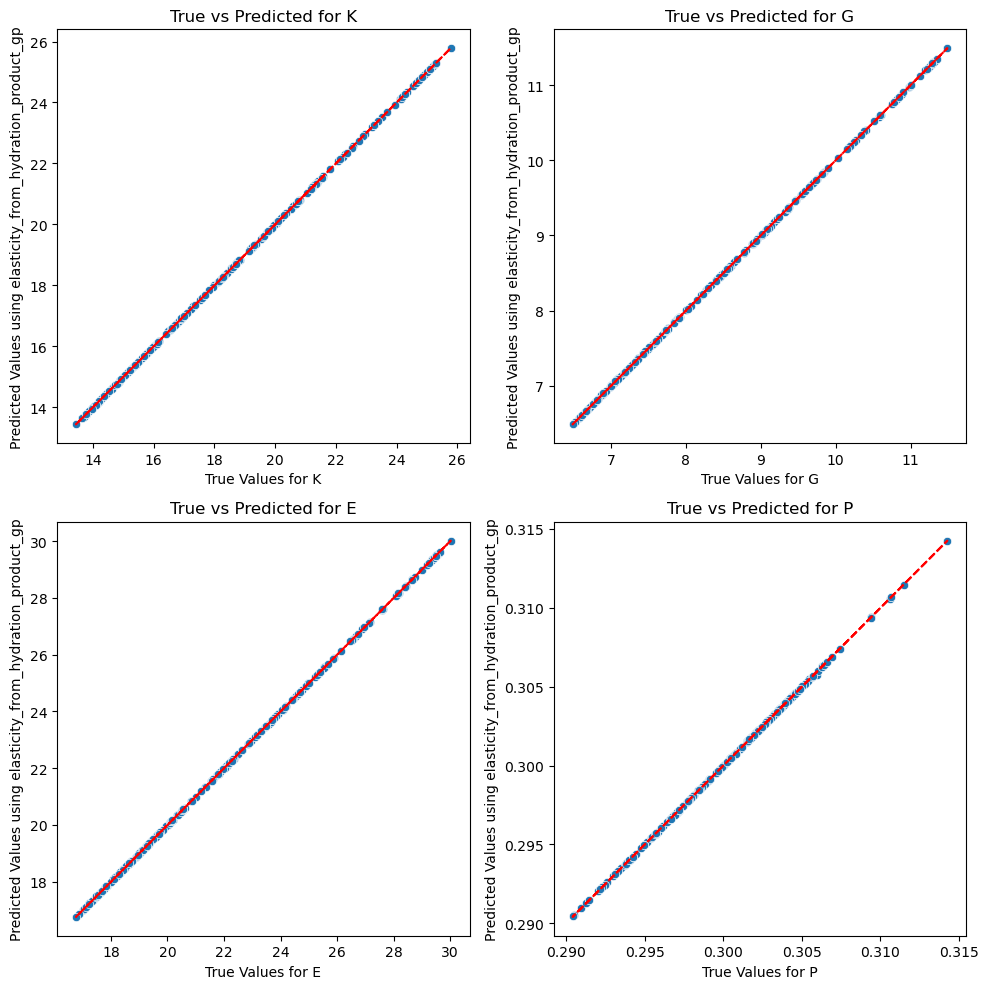

In [17]:
########################################################################################
#
#                    Validation of the neural net
#
########################################################################################
# assert the loss of the model
predicted_values = gpgh.predict(test_output_gp)
model_perf = evaluate_predictions(test_elastic_gp, predicted_values)
model_perf.to_csv('model_perf/gpgh_2^10.csv')

# Plot the true vs predicted values
plot_true_vs_predicted(test_elastic_gp, predicted_values, 'elasticity_from_hydration_product_gp')

# Combination of the model 1 and 3 and comparaison with model 2

7/7 [==============================] - 0s 1ms/step


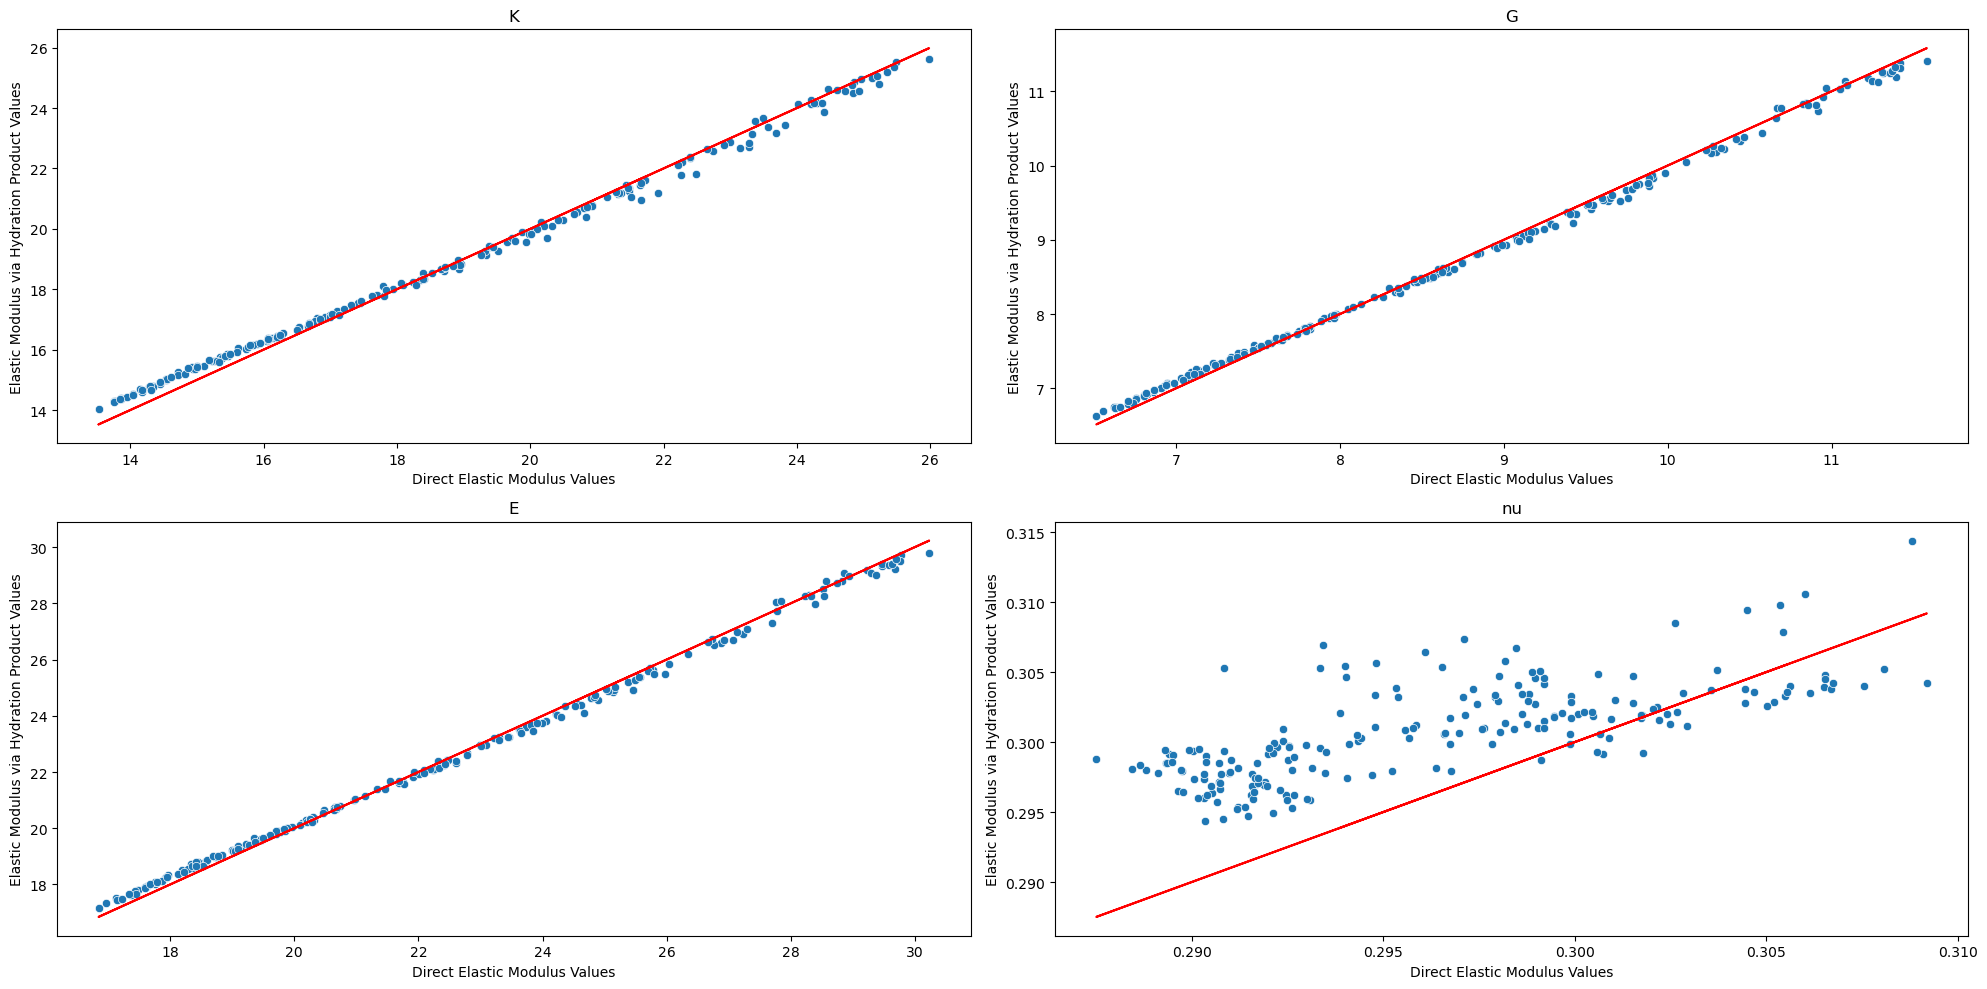

In [18]:
# for the neural networks models
predicted_values = elasticity_from_hydration_NN.predict(hydration_NN.predict(test_input_gp))
true_values = elasticity_NN.predict(test_input_gp)
plot_model1_vs_model2(true_values, predicted_values, 'comparaison direct elastic against elastic moduli through hydration product nn')

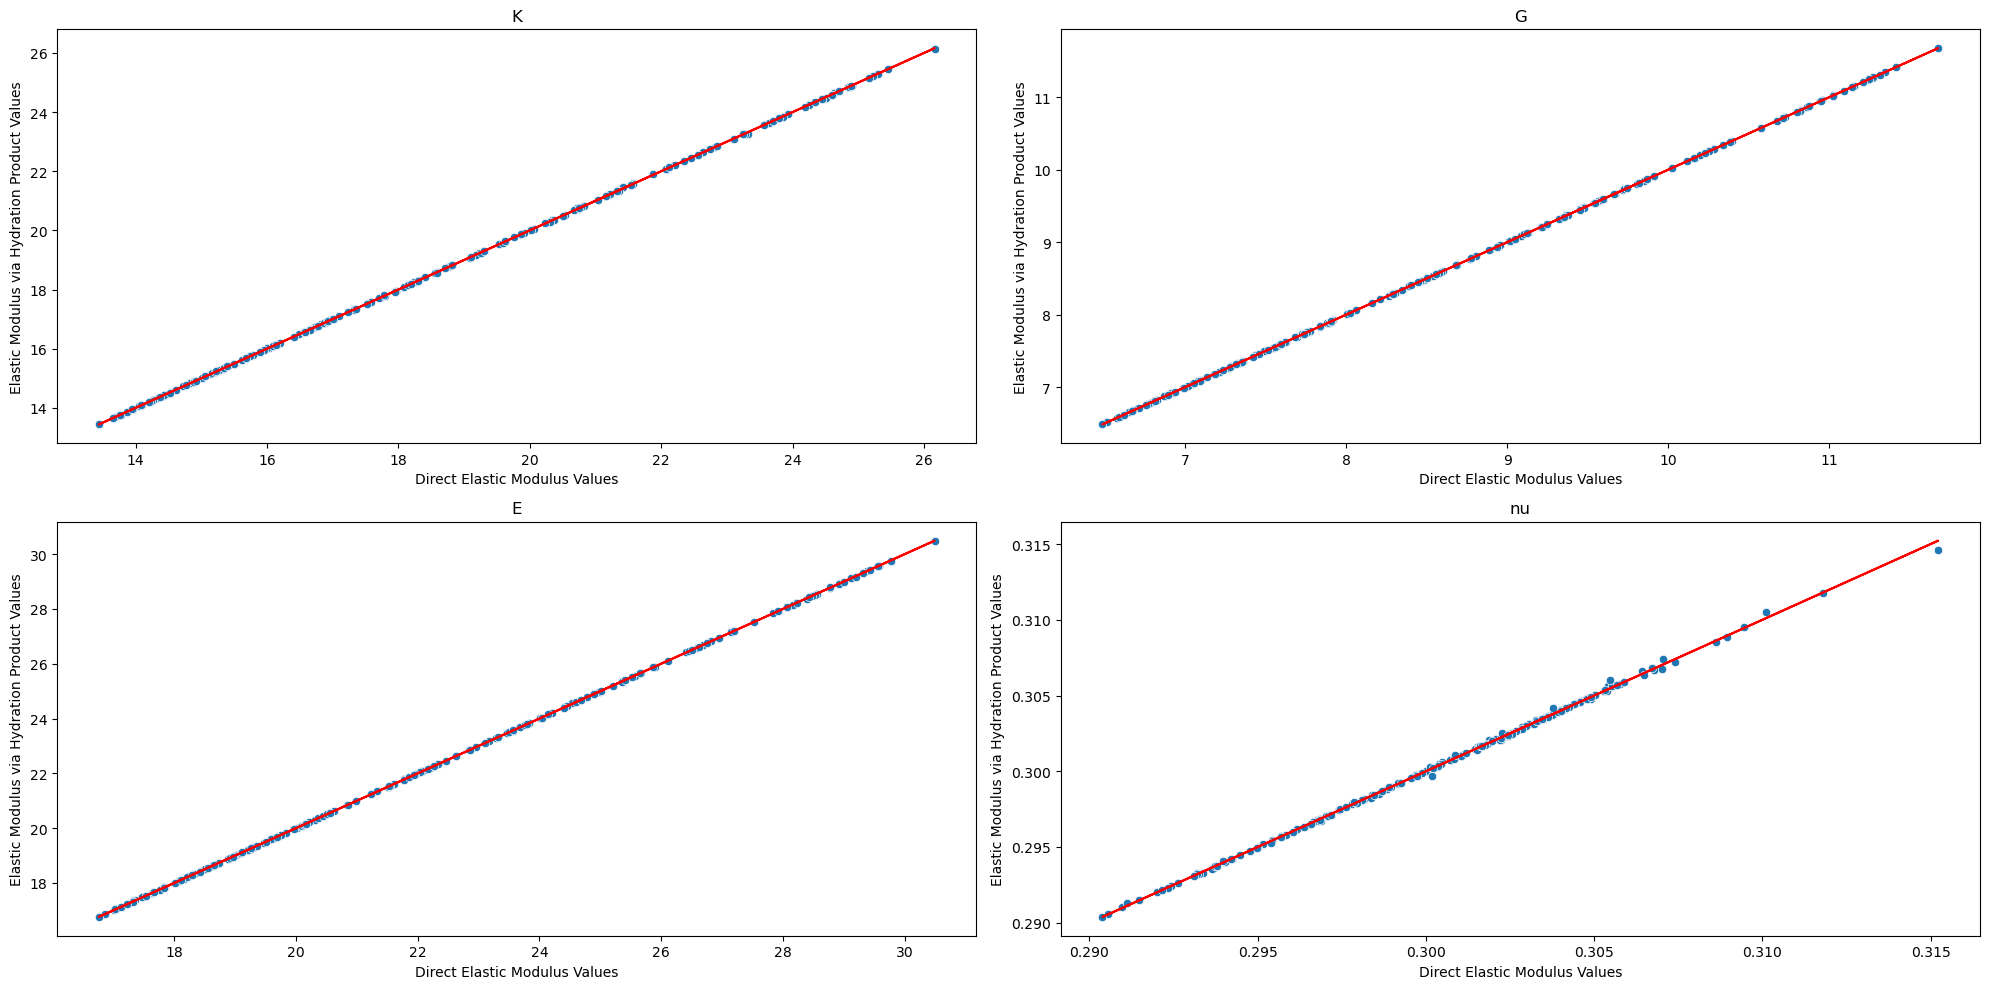

In [19]:
# For the GP model 
predicted_values = gpgh.predict(gph.predict(test_input_gp))
true_values = gpg.predict(test_input_gp)
plot_model1_vs_model2(true_values, predicted_values, 'comparaison direct elastic against elastic moduli through hydration product, gp')


# Surrogate model for the CO2 emission of a cement recipe

In [20]:
########################################################################################
#
#                   LOAD DATA
#
########################################################################################
file_path = 'data_repo/'

X = pd.read_csv(file_path+ 'recipe_data_2^15.csv',  index_col=[0])
y = pd.read_csv(file_path+ 'co2_emission_2^15.csv')
train_input, test_input, train_co2, test_co2 = train_test_split(X, y, test_size=0.1, random_state=42)

X = pd.read_csv(file_path+ 'recipe_data_2^10.csv',  index_col=[0])
y = pd.read_csv(file_path+ 'co2_emission_2^10.csv')

train_input_gp, test_input_gp, train_co2_gp, test_co2_gp = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
########################################################################################
#
#                    NEURAL NETWORK
#
########################################################################################
# Model training
#co2_NN, co2_hist = NN_co2(train_input, train_co2, test_input, test_co2)
#co2_NN.save('model/co2_2^15.h5')

# Load pretrain model
model_path = 'model/co2_2^15.h5'
co2_NN = load_model(model_path, compile=False)

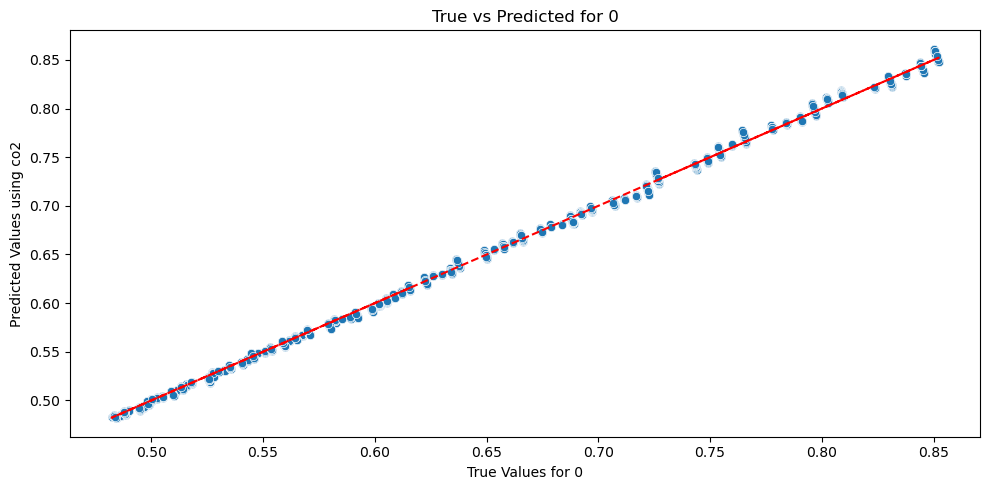

In [22]:
########################################################################################
#
#                    Validation of the neural net
#
########################################################################################
# plot the loss per epoch
#plot_loss(co2_hist)

# evaluate the model
predicted_values = co2_NN(test_input.to_numpy()).numpy()
model_perf = evaluate_predictions(test_co2, predicted_values)
model_perf.to_csv('model_perf/co2_NN_2^15.csv')

# plot the true vs predicted values
plot_true_vs_predicted(test_co2, predicted_values, 'co2')

In [23]:
########################################################################################
#
#                    Gaussian Process
#
########################################################################################
kernel = Matern()
gpc = GaussianProcessRegressor(kernel).fit(train_input_gp, train_co2_gp)
print('The score for the Gaussian Process for hydration is: ', gpc.score(train_input_gp, train_co2_gp))
predict = (gpc.predict(test_input_gp))
print('The mean square error of the Gaussian Process on the test set is: ', np.mean((predict-test_co2_gp.to_numpy())**2))

The score for the Gaussian Process for hydration is:  0.9999999999998048
The mean square error of the Gaussian Process on the test set is:  0.02266040350157975


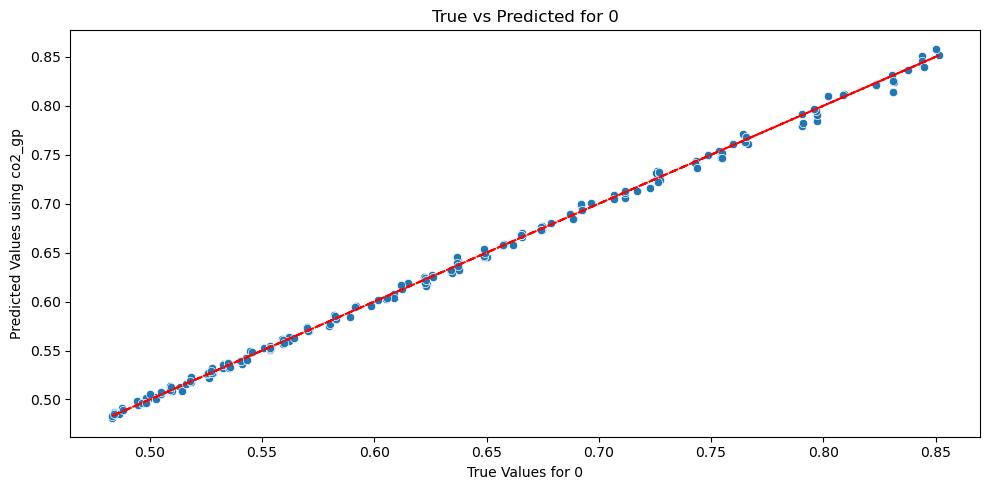

In [24]:
########################################################################################
#
#                    Validation of the GP
#
########################################################################################
predicted_values = gpc.predict(test_input_gp)
model_perf = evaluate_predictions(test_co2_gp, predicted_values)
model_perf.to_csv('model_perf/gpc_2^10.csv')

plot_true_vs_predicted(test_co2_gp, predicted_values, 'co2_gp')

# Optimization

### Standard Optimization

Standard optimisation of CO2 using G > 10 as constraint (see DNN opt)

Run this code in the root environement otherwise it does not work for package compatibility reason

In [27]:
# OPTIMIZATION USING GP

#get initial points for the optimization task
initial_points = pd.read_csv('data_repo/recipe_data_2^7.csv', index_col=[0])
initial_points.loc[0]

C3S               60.086032
C2S               26.059775
C3A               12.064128
C4AF               7.427653
RH                 1.000000
T                 25.000000
fineness         385.000000
wc                 0.419176
CSH2               2.191757
limestone          4.469088
silica_fume        5.958785
GGBFS              7.448481
fly_ash            4.767028
calcined_clay     13.407265
Name: 0, dtype: float64

In [29]:
emission_dic ={'opc' : 0.85, # in ton of CO2
          'fly_ash' : 0.004,# values from Alsalaman + al
          'silica_fume' : 0.014, 
          'GGBFS' : 0.052,
          'metakolain' : 0.33,
          'fine_aggregate' :0.0048,
          'coarse_aggregate':0.0048,
          'admixture': 1.88,
          'sodium_hydroxide': 1.915,
          'sodium_silicate': 1.222,
          'limestone': 0.00313,  #value from A Review of Carbon Footprint Reduction in Construction Industry, from Design to Operation  Sizirici + al
          'calcined_clay': 0.196, #best value from Limestone calcined clay cement as a low-carbon solution to meet expanding cement demand in emerging economies, Yudiesky + al.
          'pozzolan': 0.00313, #value not found (so same as limestone as there are both existing in natural state
}

def co2_emission_fct(recipe_dic):
    ''' Function to compute the CO2 emission of a given recipe'''
    co2_emission = 100*emission_dic['opc']
    material_mass = 100
    for i in ['limestone', 'silica_fume', 'GGBFS', 'fly_ash', 'calcined_clay']:
        switch={'limestone': recipe_dic[-5],
                'silica_fume':recipe_dic[-4],
                'GGBFS':recipe_dic[-3],
                'fly_ash':recipe_dic[-2],
                'calcined_clay': recipe_dic[-1],
                }
        mass = switch.get(i)
        print(mass)
        co2_emission += emission_dic[i]* mass
        material_mass += mass
    return co2_emission/material_mass

In [31]:
initial_points.loc[0][-5]

4.469088474288583

In [24]:
# OPTIMIZATION USING GP

#get initial points for the optimization task
initial_points = pd.read_csv('data_repo/recipe_data_2^7.csv', index_col=[0])

#do the optimization task
min_list_gp = opt_gp(gpc, gpg, initial_points.to_numpy())

Initialization of the constraints
Begining of the 0th iteration
Result for the 0th iteration: [ 77.539074    10.30320978   4.06398615   7.05064066   1.
  25.         385.           1.02538369   1.04308942   3.23729004
   4.28749096   5.95963761   4.4684265   10.30256178] with CO2 emissions of 0.6815871290276414
Begining of the 1th iteration
Result for the 1th iteration: [ 79.743859     3.70224478   4.04206606   8.65918788   1.
  25.         385.           0.75041192   3.85264227   3.39655298
   4.72830576   6.80003877   2.38191106  11.38594559] with CO2 emissions of 0.6812473869342197
Begining of the 2th iteration
Result for the 2th iteration: [ 79.98714076   7.77132356   4.05004268   7.00826172   1.
  25.         385.           0.38909934   1.1832313    5.04176514
   3.96736603   4.17895324   4.04050764  11.51962418] with CO2 emissions of 0.6801075801667452
Begining of the 3th iteration
Result for the 3th iteration: [ 61.67222664   9.87229954  10.03369252  14.75558253   1.
  25.      

KeyboardInterrupt: 

In [ ]:
# Look for the minimal value of the above algorithm

co2_value= 100 #set initial co2 value unrealistically high
min_recipe = []

for value, key in enumerate(min_list_gp):
    if min_list_gp[key]['co2_value'] < co2_value:
        co2_value = min_list_gp[key]['co2_value']
        min_recipe = min_list_gp[key]['recipe']
print(f'The best recipe is {min_recipe} with CO2 emissions of {co2_value}')

pd.DataFrame(min_recipe, index =train_input.columns.to_list()) 

In [ ]:
# OPTIMIZATION USING GP

#get initial points for the optimization task 
initial_points = pd.read_csv('data_repo/recipe_data_2^4.csv', index_col=[0])

#do the optimization task
min_list_nn = opt(co2_NN, elasticity_NN, initial_points.to_numpy())

In [ ]:
# Look for the minimal value of the above algorithm
co2_value= 100
min_recipe = []

for value, key in enumerate(min_list_nn):
    if min_list_nn[key]['co2_value'] < co2_value:
        co2_value = min_list_nn[key]['co2_value']
        min_recipe = min_list_nn[key]['recipe']
print(f'The best recipe is {min_recipe} with CO2 emissions of {co2_value}')

pd.DataFrame(min_recipe, index =train_input.columns.to_list()) 

In [ ]:
# Hyperparameter optimization for the neural network

# for hydration
#hyp_param_opt(train_input, train_output, test_input, test_output)

#for phases to elastic moduli
#hyp_param_opt(train_input, train_elastic, test_input, test_elastic)

#for phases to energy
#hyp_param_opt(train_input, train_energy, test_input, test_energy)

#for phases to CO2
#hyp_param_opt(train_input, train_co2, test_input, test_co2)

In [ ]:
# Algo for Bayesian Optimization
# Not working for now (the algo does not find new points after the initialization

#BO(gpc, gpg, train_input.to_numpy()) 

In [ ]:
# ISMO algorithm TO DO
N = 1
train_input = pd.read_csv('data_repo/recipe_data_2^10.csv', index_col=[0])
train_output = pd.read_csv('data_repo/elastic_moduli_2^10.csv', index_col=[0])
INPUT_DIM = train_input.columns.shape[0]
OUTPUT_DIM = train_output.columns.shape[0]

model_layers = [tf.keras.layers.InputLayer(input_shape=(INPUT_DIM,))]
for i in range(10):
    model_layers.append(tf.keras.layers.Dense(50, activation='relu'))

model_layers.append(tf.keras.layers.Dense(OUTPUT_DIM))
model = tf.keras.models.Sequential(model_layers)   

model.summary()
    
X = tf.convert_to_tensor(train_input, dtype = tf.float32)
y = tf.convert_to_tensor(train_output, dtype = tf.float32)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                 metrics = [tf.keras.losses.MeanSquaredError()])
MAX_EPOCHS = 100

training_set = pd.read_csv('data_repo/recipe_data_2^4.csv', index_col=[0])
output_set = pd.read_csv('data_repo/elastic_moduli_2^4.csv', index_col=[0])

mod = 0
def ismo_step(training_set, output_set, co2_NN):
    ''' Implementation of the ISMO step from https://arxiv.org/pdf/2008.05730.pdf '''
    initial_value_index = np.random.randint(0, training_set.shape[0]-1, size = N)
    for i in range(N):
        index = initial_value_index[i]
        local_opt, co2_local_opt = opt_ismo(model, training_set.iloc[index])
        training_set = np.concatenate((training_set, local_opt.reshape(1,-1)))
        print(co2_local_opt.reshape(1,-1))
        output_set = np.concatenate((output_set, gpg.predict(local_opt.reshape(1,-1)).reshape(1,-1)))
    return training_set, output_set, model

for i in range(10):
    print('Initializing an ISMO step')
    model.fit(training_set, output_set, verbose = 0)
    print('Search for locally optimal data')
    training_set, output_set, model = ismo_step(training_set, output_set, model)

In [7]:
# Compute the time for evaluation of the models
import time
inputs = [pd.read_csv('data_repo/recipe_data_1.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_4.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^3.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^4.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^5.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^6.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^7.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^8.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^10.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^11.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^15.csv', index_col=[0])  
        ]
times_NN = []
times_gp = []
for data in inputs:
    add_time_NN = 0
    add_time_gp = 0
    #for index, row in data.iterrows():
        #row = tf.reshape(tf.constant(row.to_numpy()), (1,-1))
    start_time = time.time()
    hydration_NN.predict(data, verbose=0)
    elapsed_time = time.time() - start_time
    times_NN.append(elapsed_time)
    #add_time_NN += elapsed_time
    start_time = time.time()
    gph.predict(data)#.to_numpy().reshape(1,-1)
    elapsed_time_gp = time.time() - start_time
    #add_time_gp += elapsed_time
    times_gp.append(elapsed_time_gp)

file_path = "time/time_hydration_nn.txt"
with open(file_path, 'w') as file:
    for item in times_NN:
        file.write("%s\n" % item)
file_path = "time/time_hydration_gp.txt"
with open(file_path, 'w') as file:
    for item in times_gp:
        file.write("%s\n" % item)

In [ ]:
# Compute the time for evaluation of the models
import time
inputs = [pd.read_csv('data_repo/recipe_data_1.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_4.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^3.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^4.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^5.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^6.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^7.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^8.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^10.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^11.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^15.csv', index_col=[0])  
        ]
times_NN = []
times_gp = []
for data in inputs:
    add_time_NN = 0
    add_time_gp = 0
    #for index, row in data.iterrows():
        #row = tf.reshape(tf.constant(row.to_numpy()), (1,-1))
    start_time = time.time()
    elasticity_NN.predict(data, verbose=0)
    elapsed_time = time.time() - start_time
    times_NN.append(elapsed_time)
    #add_time_NN += elapsed_time
    start_time = time.time()
    gpg.predict(data)#.to_numpy().reshape(1,-1)
    elapsed_time_gp = time.time() - start_time
    #add_time_gp += elapsed_time
    times_gp.append(elapsed_time_gp)

file_path = "time/time_elasticity_nn.txt"
with open(file_path, 'w') as file:
    for item in times_NN:
        file.write("%s\n" % item)
file_path = "time/time_elasticity_gp.txt"
with open(file_path, 'w') as file:
    for item in times_gp:
        file.write("%s\n" % item)

In [ ]:
import time
inputs = [pd.read_csv('data_repo/recipe_data_1.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_4.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^3.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^4.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^5.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^6.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^7.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^8.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^10.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^11.csv', index_col=[0]),
          pd.read_csv('data_repo/recipe_data_2^15.csv', index_col=[0])  
        ]
times_NN = []
times_gp = []
for data in inputs:
    add_time_NN = 0
    add_time_gp = 0
    #for index, row in data.iterrows():
        #row = tf.reshape(tf.constant(row.to_numpy()), (1,-1))
    start_time = time.time()
    co2_NN.predict(data, verbose=0)
    elapsed_time = time.time() - start_time
    times_NN.append(elapsed_time)
    #add_time_NN += elapsed_time
    start_time = time.time()
    gpc.predict(data)#.to_numpy().reshape(1,-1)
    elapsed_time_gp = time.time() - start_time
    #add_time_gp += elapsed_time
    times_gp.append(elapsed_time_gp)

file_path = "time/time_co2_nn.txt"
with open(file_path, 'w') as file:
    for item in times_NN:
        file.write("%s\n" % item)
file_path = "time/time_co2_gp.txt"
with open(file_path, 'w') as file:
    for item in times_gp:
        file.write("%s\n" % item)